In [2]:
#Tratamieto de datos
import pandas as pd #
import numpy as np  #
# ==============================================================================================================================================================

#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
# ==============================================================================================================================================================

#Procesado y Modelado
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
# ==============================================================================================================================================================

# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
# Configuración warnings
# ==============================================================================================================================================================

#Configuración warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_excel(r"D:\Never Urueta\2023\Algoritmos Tesis\Data.xlsx") 

In [4]:
data1 = data.drop(["PBA", "CF", "Indicador", "DESTINO", "CAPACIDAD DEL CUARTO FRIO  "], axis=1)

In [5]:
data1["Rechazados_Binario"] = data1["Rechazados"] 
data1.loc[data1["Rechazados_Binario"] > 0, "Rechazados_Binario"] = 1
print(data1.Rechazados_Binario.value_counts().sort_index())


0    1329
1     585
Name: Rechazados_Binario, dtype: int64


# Umbral de Clasificación Esperado
En el 69.4% de las maduraciones No se rechazan canales y en el 30.6% sí se rechazan. Un modelo de clasificación que sea útil debe de ser capaz de predecir correctamente un porcentaje de observaciones por encima del porcentaje de la clase mayoritaria. En este caso, el umbral de referencia que se tiene que superar es del 69.4%.

In [6]:
###VARIABLES CATEGORICAS Y NUMERICAS
features = list(set(data1.columns.values) - set(['ID', 'TARGET']))
cat_features = [feat for feat in features if data1[feat].dtype.name in ['category', 'object']]
num_features = list(set(features) - set(cat_features))

print(f"Factores Categoricos: \n {cat_features}")
print(f"Factores Numéricos: \n {num_features}")

Factores Categoricos: 
 ['Refrigeracion', 'Franja2', 'Dia_Semana', 'TIPO_CAP_CF', 'pH_Requisito', 'Franja1']
Factores Numéricos: 
 ['Ti2', 'PPPCF', 'Ocupacion', 'VT1', 'Temp1', 'Tamin', 'Rechazados', 'Taamax', 'Temp3', 'Canales', 'Temp2', 'Ti1', 'VT2', 'Rechazados_Binario']


In [7]:
data1.isnull().sum() #Datos faltantes

Dia_Semana             0
Temp1                  0
Franja1                0
Temp2                  0
Franja2                0
VT1                    0
Ti1                    0
Temp3                  0
Ti2                    0
VT2                    0
Refrigeracion          0
Canales                0
PPPCF                  0
Ocupacion              0
pH_Requisito           0
Tamin                 29
Taamax                29
TIPO_CAP_CF            0
Rechazados             0
Rechazados_Binario     0
dtype: int64

In [8]:
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


In [9]:
data1.describe()

,Temp1,Temp2,VT1,Ti1,Temp3,Ti2,VT2,Canales,PPPCF,Ocupacion,Tamin,Taamax,Rechazados,Rechazados_Binario
count,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000,1914.000000
mean,3.080371,11.733454,8.653083,2.129855,2.766437,33.368273,-8.955836,136.827586,22.518286,93.083697,23.857913,32.530543,0.552247,0.305643
std,1.614204,3.365969,3.251896,1.135182,1.774718,14.483894,3.597810,30.208935,15.420267,11.038884,0.960839,1.664524,0.930765,0.460799
min,-4.700000,1.400000,-3.200000,0.166667,-5.600000,24.000000,-35.200000,27.000000,3.991370,19.354839,20.400000,27.200000,0.000000,0.000000
25%,2.100000,10.000000,6.800000,1.583333,2.000000,24.250000,-10.900000,140.000000,17.022934,91.888046,23.300000,31.600000,0.000000,0.000000
50%,2.900000,11.500000,8.500000,1.883333,3.000000,25.250000,-9.000000,150.000000,19.326683,96.774194,24.000000,32.600000,0.000000,0.000000
75%,3.900000,13.800000,10.500000,2.483333,3.800000,37.757500,-7.000000,155.000000,23.219814,100.000000,24.500000,33.600000,1.000000,1.000000
max,18.200000,39.400000,36.800000,16.183333,7.300000,110.200000,4.200000,239.000000,100.000000,104.761905,26.000000,36.300000,5.000000,1.000000


In [10]:
data1.Temp3.unique

<bound method Series.unique of 0       4.0
1       4.0
2       4.4
3       4.3
4       5.4
       ... 
1909    3.0
1910    1.3
1911    1.8
1912    0.9
1913   -1.4
Name: Temp3, Length: 1914, dtype: float64>

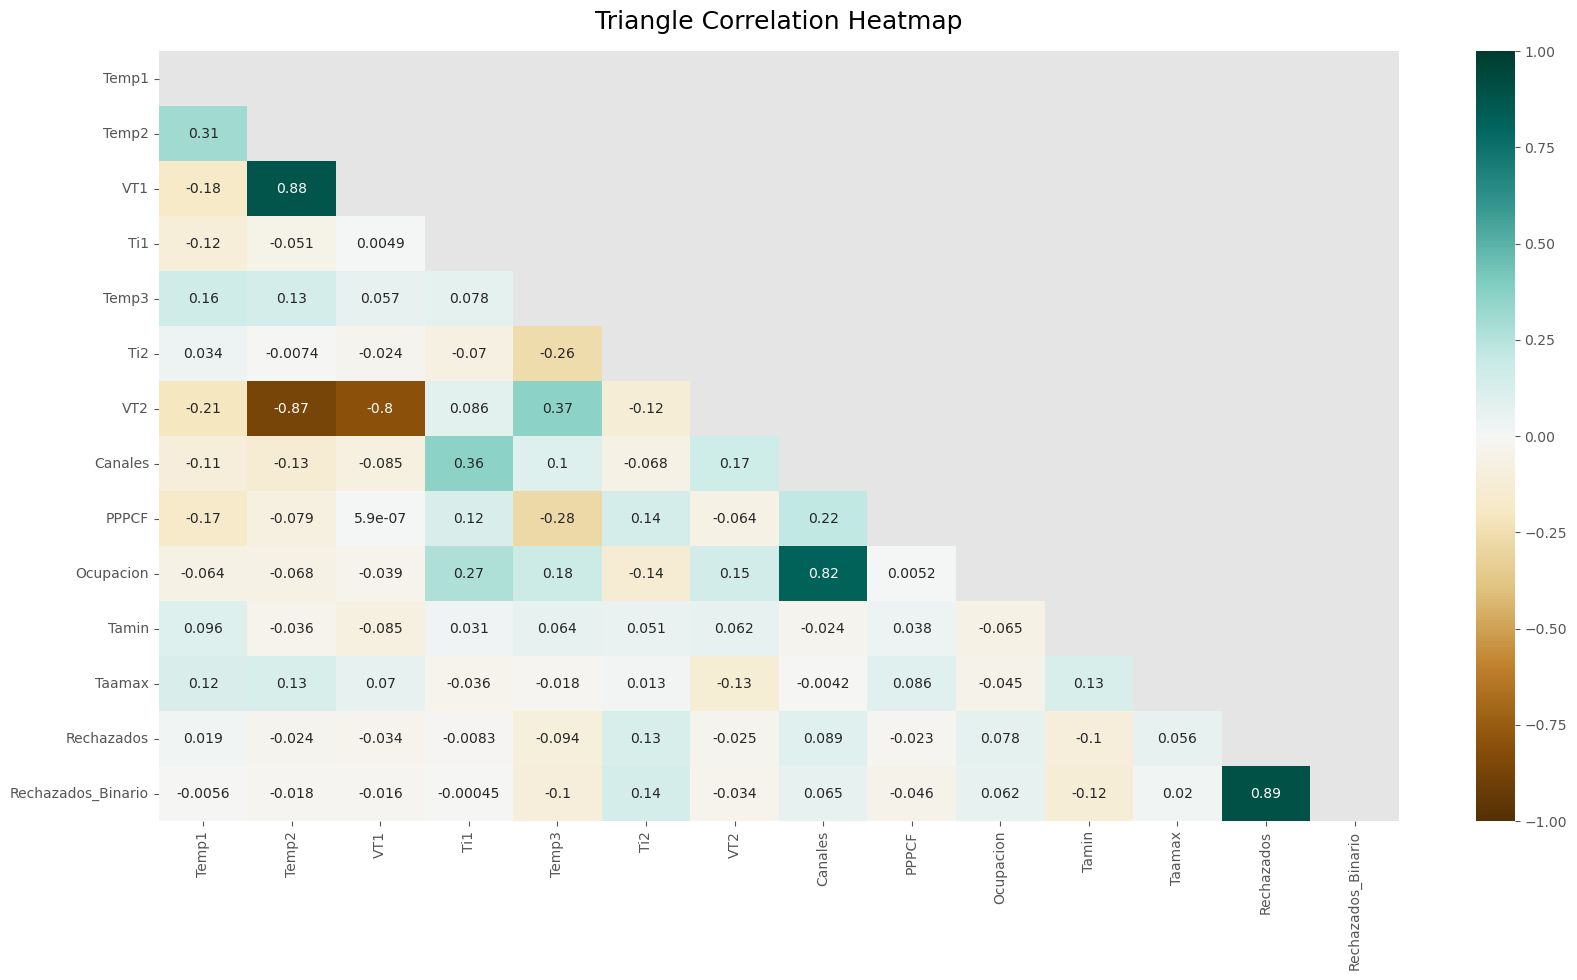

In [11]:
plt.figure(figsize=(20,10))
mask = np.triu(np.ones_like(data1.corr(), dtype=np.bool))
heatmap = sns.heatmap(data1.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);
plt.show()

In [12]:
data1 = data1.drop(["VT1", "VT2", "Rechazados", "Canales"], axis=1)

In [13]:
data1 = pd.get_dummies(data1, drop_first = True, columns = ["Franja1", "Franja2", "Dia_Semana"]) # el parámetro drop first la primera categoría, para evitar problemas de multicolinealidad
data1 = pd.get_dummies(data1, columns = ["Refrigeracion", "pH_Requisito", "TIPO_CAP_CF"]) 

In [14]:
data1.columns

Index(['Temp1', 'Temp2', 'Ti1', 'Temp3', 'Ti2', 'PPPCF', 'Ocupacion', 'Tamin',
       'Taamax', 'Rechazados_Binario', 'Franja1_MAÑANA', 'Franja1_MEDIO_DIA',
       'Franja1_NOCHE', 'Franja1_TARDE', 'Franja2_MAÑANA', 'Franja2_MEDIO_DIA',
       'Franja2_NOCHE', 'Franja2_TARDE', 'Dia_Semana_lunes',
       'Dia_Semana_martes', 'Dia_Semana_miércoles', 'Dia_Semana_sábado',
       'Dia_Semana_viernes', 'Refrigeracion_AMONIACO', 'Refrigeracion_GLICOL',
       'pH_Requisito_Mi_5.8', 'pH_Requisito_Mi_6', 'TIPO_CAP_CF_C1',
       'TIPO_CAP_CF_C2', 'TIPO_CAP_CF_C3', 'TIPO_CAP_CF_PBA2'],
      dtype='object')

In [15]:
print("Capacidad Tipo 1:", data1.TIPO_CAP_CF_C1.sum(),'\n',
      "Capacidad Tipo 2:", data1.TIPO_CAP_CF_C2.sum(),'\n',
      "Capacidad Tipo 3:", data1.TIPO_CAP_CF_C3.sum(),'\n',
      "Capacidad Frigosinú:", data1.TIPO_CAP_CF_PBA2.sum())

Capacidad Tipo 1: 187 
 Capacidad Tipo 2: 124 
 Capacidad Tipo 3: 1531 
 Capacidad Frigosinú: 72


In [16]:
data1 = data1.drop(["Refrigeracion_GLICOL", "pH_Requisito_Mi_6", "TIPO_CAP_CF_PBA2"], axis=1)

In [17]:
data1 = sm.add_constant(data1)
modelo=sm.Logit(data1["Rechazados_Binario"],data1.drop(["Rechazados_Binario"], axis=1))
modelo=modelo.fit()
modelo.summary()

Optimization terminated successfully.
         Current function value: 0.562399
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Rechazados_Binario   No. Observations:                 1914
Model:                          Logit   Df Residuals:                     1886
Method:                           MLE   Df Model:                           27
Date:                Tue, 13 Jun 2023   Pseudo R-squ.:                 0.08638
Time:                        20:59:27   Log-Likelihood:                -1076.4
converged:                       True   LL-Null:                       -1178.2
Covariance Type:            nonrobust   LLR p-value:                 5.260e-29
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0517      2.175     -0.024      0.981      -4.315       4.212
Temp1                     -0.0371      0.039     -0.956      0.339      -0.113       0.039
Temp2                     -0.0034      0.018     -0.192      0.847      -0.039       0.032
Ti1                       -0.0290      0.060     -0.485      0.628      -0.146       0.088
Temp3                     -0.1462      0.033     -4.433      0.000      -0.211      -0.082
Ti2                        0.0240      0.004      5.854      0.000       0.016       0.032
PPPCF                      0.0143      0.009      1.618      0.106      -0.003       0.032
Ocupacion                  0.0074      0.007      1.041      0.298      -0.007       0.021
Tamin                     -0.3094      0.056     -5.539      0.000      -0.419      -0.200
Taamax                     0.0663      0.033      2.010      0.044       0.002       0.131
Franja1_MAÑANA            -0.6371      0.906     -0.703      0.482      -2.414       1.140
Franja1_MEDIO_DIA         -0.4849      0.888     -0.546      0.585      -2.225       1.256
Franja1_NOCHE             -0.6869      0.865     -0.794      0.427      -2.383       1.009
Franja1_TARDE             -0.6660      0.878     -0.759      0.448      -2.386       1.054
Franja2_MAÑANA            -0.8757      0.589     -1.486      0.137      -2.031       0.279
Franja2_MEDIO_DIA         -0.7412      0.563     -1.316      0.188      -1.845       0.363
Franja2_NOCHE             -0.6829      0.462     -1.478      0.139      -1.588       0.223
Franja2_TARDE             -0.4796      0.486     -0.986      0.324      -1.433       0.474
Dia_Semana_lunes           0.2873      0.186      1.547      0.122      -0.077       0.651
Dia_Semana_martes          0.2574      0.178      1.447      0.148      -0.091       0.606
Dia_Semana_miércoles       0.2270      0.178      1.275      0.202      -0.122       0.576
Dia_Semana_sábado         -0.2258      0.189     -1.198      0.231      -0.595       0.144
Dia_Semana_viernes        -0.4310      0.196     -2.201      0.028      -0.815      -0.047
Refrigeracion_AMONIACO     0.1251      0.128      0.978      0.328      -0.126       0.376
pH_Requisito_Mi_5.8        0.4420      0.130      3.400      0.001       0.187       0.697
TIPO_CAP_CF_C1             3.8949      1.071      3.635      0.000       1.795       5.995
TIPO_CAP_CF_C2             4.0832      1.049      3.894      0.000       2.028       6.138
TIPO_CAP_CF_C3             4.1397      0.978      4.233      0.000       2.223       6.057
==========================================================================================
"""

In [18]:
#Multicolinealidad - VIFs
pd.Series([variance_inflation_factor(data1.drop(["Rechazados_Binario"], axis=1), i) 
               for i in range(data1.drop(["Rechazados_Binario"], axis=1).shape[1])], 
              index=data1.drop(["Rechazados_Binario"], axis=1).columns)              

const                     1514.556230
Temp1                        1.259138
Temp2                        1.285794
Ti1                          1.505831
Temp3                        1.286710
Ti2                          1.310146
PPPCF                        4.670672
Ocupacion                    1.843314
Tamin                        1.069315
Taamax                       1.090818
Franja1_MAÑANA              61.402552
Franja1_MEDIO_DIA           43.562592
Franja1_NOCHE               31.775524
Franja1_TARDE               69.290192
Franja2_MAÑANA               9.951593
Franja2_MEDIO_DIA           16.074786
Franja2_NOCHE               14.950315
Franja2_TARDE               20.890377
Dia_Semana_lunes             1.698144
Dia_Semana_martes            1.711234
Dia_Semana_miércoles         1.716613
Dia_Semana_sábado            1.794395
Dia_Semana_viernes           1.754715
Refrigeracion_AMONIACO       1.535153
pH_Requisito_Mi_5.8          1.167913
TIPO_CAP_CF_C1              15.188822
TIPO_CAP_CF_

In [19]:
#Eliminando la Multicolinealidad
data1 = data1.drop([ "Franja1_MAÑANA", "Franja1_MEDIO_DIA","Franja1_NOCHE", "Franja1_TARDE", "Franja2_TARDE", "TIPO_CAP_CF_C3"], axis=1)

In [20]:
pd.Series([variance_inflation_factor(data1.drop(["Rechazados_Binario"], axis=1), i) 
               for i in range(data1.drop(["Rechazados_Binario"], axis=1).shape[1])], 
              index=data1.drop(["Rechazados_Binario"], axis=1).columns)        

const                     1148.411297
Temp1                        1.215052
Temp2                        1.240060
Ti1                          1.227530
Temp3                        1.249140
Ti2                          1.243720
PPPCF                        1.502551
Ocupacion                    1.777782
Tamin                        1.062404
Taamax                       1.077592
Franja2_MAÑANA               1.167011
Franja2_MEDIO_DIA            1.217225
Franja2_NOCHE                1.221952
Dia_Semana_lunes             1.692941
Dia_Semana_martes            1.702729
Dia_Semana_miércoles         1.711361
Dia_Semana_sábado            1.759828
Dia_Semana_viernes           1.745446
Refrigeracion_AMONIACO       1.525699
pH_Requisito_Mi_5.8          1.136335
TIPO_CAP_CF_C1               2.063130
TIPO_CAP_CF_C2               1.242790
dtype: float64

In [21]:
#Nuevo modelo
model=sm.Logit(data1["Rechazados_Binario"],data1.drop(["Rechazados_Binario"], axis=1))
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.570467
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Rechazados_Binario   No. Observations:                 1914
Model:                          Logit   Df Residuals:                     1892
Method:                           MLE   Df Model:                           21
Date:                Tue, 13 Jun 2023   Pseudo R-squ.:                 0.07327
Time:                        20:59:27   Log-Likelihood:                -1091.9
converged:                       True   LL-Null:                       -1178.2
Covariance Type:            nonrobust   LLR p-value:                 7.904e-26
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.8311      1.781      1.590      0.112      -0.660       6.322
Temp1                     -0.0029      0.036     -0.078      0.938      -0.074       0.069
Temp2                     -0.0100      0.017     -0.577      0.564      -0.044       0.024
Ti1                       -0.0330      0.053     -0.618      0.537      -0.138       0.072
Temp3                     -0.1252      0.032     -3.898      0.000      -0.188      -0.062
Ti2                        0.0284      0.004      7.091      0.000       0.021       0.036
PPPCF                     -0.0187      0.005     -3.594      0.000      -0.029      -0.008
Ocupacion                  0.0113      0.007      1.650      0.099      -0.002       0.025
Tamin                     -0.2885      0.055     -5.220      0.000      -0.397      -0.180
Taamax                     0.0593      0.033      1.824      0.068      -0.004       0.123
Franja2_MAÑANA            -0.4693      0.199     -2.359      0.018      -0.859      -0.079
Franja2_MEDIO_DIA         -0.3295      0.151     -2.186      0.029      -0.625      -0.034
Franja2_NOCHE             -0.3555      0.132     -2.687      0.007      -0.615      -0.096
Dia_Semana_lunes           0.2684      0.184      1.457      0.145      -0.093       0.629
Dia_Semana_martes          0.2591      0.177      1.467      0.142      -0.087       0.605
Dia_Semana_miércoles       0.2076      0.177      1.175      0.240      -0.139       0.554
Dia_Semana_sábado         -0.3258      0.187     -1.745      0.081      -0.692       0.040
Dia_Semana_viernes        -0.4886      0.196     -2.498      0.012      -0.872      -0.105
Refrigeracion_AMONIACO     0.1198      0.127      0.941      0.347      -0.130       0.369
pH_Requisito_Mi_5.8        0.5393      0.130      4.149      0.000       0.284       0.794
TIPO_CAP_CF_C1            -0.5441      0.269     -2.022      0.043      -1.072      -0.017
TIPO_CAP_CF_C2            -0.2950      0.242     -1.219      0.223      -0.769       0.179
==========================================================================================
"""

## Solo Variables Significativas 

In [22]:
data2 = data1.drop(["Temp1", "Temp2", "Ti1", "Ocupacion", "Taamax","Dia_Semana_lunes", "Dia_Semana_martes", "Dia_Semana_miércoles", "Dia_Semana_sábado", "Refrigeracion_AMONIACO","TIPO_CAP_CF_C2"], axis=1)

### Donde: 

In [23]:
# Dividimos los conjuntos de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(data2.drop(["Rechazados_Binario"], axis=1), data2["Rechazados_Binario"], train_size=0.65, random_state=1234)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [24]:
#Entrenamosel modelo y obtenemos accuracy
logit_model= sm.Logit(y_train, X_train)
logit_model.fit().summary()

Optimization terminated successfully.
         Current function value: 0.578217
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Rechazados_Binario   No. Observations:                 1244
Model:                          Logit   Df Residuals:                     1233
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Jun 2023   Pseudo R-squ.:                 0.06831
Time:                        20:59:28   Log-Likelihood:                -719.30
converged:                       True   LL-Null:                       -772.04
Covariance Type:            nonrobust   LLR p-value:                 4.350e-18
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.1043      1.566      3.898      0.000       3.035       9.174
Temp3                  -0.1240      0.038     -3.241      0.001      -0.199      -0.049
Ti2                     0.0252      0.005      5.536      0.000       0.016       0.034
PPPCF                  -0.0154      0.006     -2.583      0.010      -0.027      -0.004
Tamin                  -0.3021      0.066     -4.544      0.000      -0.432      -0.172
Franja2_MAÑANA         -0.4694      0.241     -1.951      0.051      -0.941       0.002
Franja2_MEDIO_DIA      -0.2007      0.182     -1.102      0.271      -0.558       0.156
Franja2_NOCHE          -0.4599      0.161     -2.863      0.004      -0.775      -0.145
Dia_Semana_viernes     -0.6096      0.199     -3.067      0.002      -0.999      -0.220
pH_Requisito_Mi_5.8     0.5876      0.160      3.680      0.000       0.275       0.900
TIPO_CAP_CF_C1         -0.6166      0.245     -2.518      0.012      -1.096      -0.137
=======================================================================================
"""

## Interpretación de los resultados: Odds Ratio, Intervalos de Confianza y Pvalues

In [25]:
params = np.exp(logit_model.fit().params)
conf = np.exp(logit_model.fit().conf_int())
conf['OR'] = params
pvalue=round(logit_model.fit().pvalues,3)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
conf = conf.sort_values("pvalue")
print ((conf))

Optimization terminated successfully.
         Current function value: 0.578217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.578217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.578217
         Iterations 6
                     CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
const                   20.799122    9640.337030  447.784035   0.000
Ti2                      1.016395       1.034677    1.025495   0.000
Tamin                    0.648929       0.842157    0.739256   0.000
pH_Requisito_Mi_5.8      1.316096       2.460769    1.799614   0.000
Temp3                    0.819598       0.952176    0.883403   0.001
Dia_Semana_viernes       0.368153       0.802518    0.543552   0.002
Franja2_NOCHE            0.460851       0.864994    0.631374   0.004
PPPCF                    0.973212       0.996283    0.984680   0.010
TIPO_CAP_CF_C1           0.334042       0.872246    0.539784   0.012
Fran

### Ecuación de Regresión 
$
P = e^{\beta_0 + \beta_1 X_1} / (1 + e^{\beta_0 + \beta_1 X_1} )
$


$
logit(p) = log(p/(1−p)) = β0 + β1∗Temp3 + β2∗Ti2 + β3∗PPPCF + β4∗Tamin + β5∗Franja2MAÑANA + β6∗Franja2MEDIODIA + β7∗Franja2NOCHE + β8∗Dia Semana viernes +β9pH RequisitoMi5.8 + β10*TIPO CAPCF C1
$

# Accuracy

In [39]:
result= logit_model.fit_regularized()
accuracy = accuracy_score(y_true = y_test, y_pred = np.where(result.predict(X_test) <0.5, 0, 1), normalize = True)
print("")
print(f"Accuracy: {100*accuracy}%")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5782172580416776
            Iterations: 58
            Function evaluations: 65
            Gradient evaluations: 58

Accuracy: 70.0%


El modelo logístico creado para predecir la probabilidad de que se rechace una canal de res después de la medición de pH final es en conjunto significativo (Likelihood ratio p-value = 4.350e-21). El porcentaje de clasificación correcta en el conjunto del test es del 70%, un valor apenas por encima del umbral de 69.4% esperado por azar. Por lo tanto; es un modelo adecuedo de clasificación. 

$
logit(p) = log(p/(1−p)) = 5.8128 - 0.1087Temp3 + 0.0228Ti2 - 0.0144PPPCF - 0.2880Tamin - 0.4698Franja2MAÑANA - 0.2677Franja2MEDIODIA - 0.4046Franja2NOCHE - 0.6081DiaSemanaviernes + 0.5746pHRequisitoMi5.8 - 0.8342TIPOCAPCFC1
$

### Este modelo ajustado muestra que, manteniendo todas las demás características constantes: 


- Veremos una disminución del 11.66% en la probabilidad de rechazar un canal de res si la temeratura a la que se encuenta el cuarto frío posterior a la maduración aumenta en un grado celcius. $e^{-0.1240} = 0.8833$. Manteniendose en el rango de funcionamieto del requisito que exija cada país 

- Encontramos que hay un aumento del 2,6% en la probabilidad de rechazar una canal de res si el tiempo de maduración aumenta 1 hora posterior al requisito mínimo que es de 24 horas.    $e^{0.0252} = 1.0255$

- se reflejará que al aumentar un 1% el porcentaje de producción diaria asignado a un cuarto frío se reduce la probabilidad de rechazar una canal de res en 1.5%. $e^{-0.0154} = 0.9847$.

- Podemos observar también que el aumento de 1 grado celcius en la temperatura ambiente mínima registrada repercute en un 26.1% de disminución de la probabilidad de rechazo de una canal de res. $e^{-0.3021} = 0.73926$. 

- La probabilidad  de rechazar un canal de res si el ingreso de estas a refrigeración se termina en la noche  es 36.9% más baja que si se realiza en otra jornada $e^{-0.4499} = 0.631347$, mientras que si el ingreso se termina en la mañana la probabilidad de rechazo del canal de res es 37.5% más baja que si se terminara de ingr3sar dichos canales en otra franja de horario $e^{-0.4694} = 0.625378$. 

- Los días viernes hay menos probabilidad de rechazar un canal de res  que otros días, esta es 45.6% más baja. $e^{-0.6096} = 0.54357$. 

- Hay un 80% mas de probabilidad de rechazar una canal de res cuando dentro de la demanda de exportación se encuentra CHILE con su requisito máximo de pH de 5.8 que cuando se planea exportar co demandaque no contenga a Chile como pais receptor. $e^{0.5876} = 1.79966$. 

- En los cuartos fríos en donde la Capacidad máxima de almacenamiento es más pequeña <= 90 canales de res la probabilidad de rechazar uno es 46% mas baja que en los demás cuartos fríos con mayores capacidad de almacenamiento. Esto se da porque en la dinamica dde producción de las plantas de beneficio animal analisadas primero según la demanda diaria se llenan los cuartos con mayor capacidad hasta su tope, y las canales restante que son cantidad menores se almacenan en estos cuartos con menores capacidades $e^{-0.6166} = 0.53978$. 

# Matriz de Confusión

Una matriz de confusión es una herramienta para resumir el rendimiento de un algoritmo de clasificación. Una matriz de confusión nos dará una imagen clara del rendimiento del modelo de clasificación y los tipos de errores producidos por el modelo. Nos da un resumen de predicciones correctas e incorrectas desglosadas por cada categoría. El resumen se representa en forma tabular.


- Verdaderos positivos (TP): los verdaderos positivos ocurren cuando predecimos que una observación pertenece a una determinada clase y la observación en realidad pertenece a esa clase.

- Verdaderos negativos (TN): los verdaderos negativos ocurren cuando predecimos que una observación no pertenece a una determinada clase y la observación en realidad no pertenece a esa clase.

- Falsos positivos (FP): los falsos positivos ocurren cuando predecimos que una observación pertenece a una determinada clase, pero la observación en realidad no pertenece a esa clase. Este tipo de error se denomina error tipo I.

- Falsos negativos (FN): los falsos negativos ocurren cuando predecimos que una observación no pertenece a una determinada clase, pero la observación en realidad pertenece a esa clase. Este es un error muy grave y se llama error de tipo II.

<AxesSubplot:>

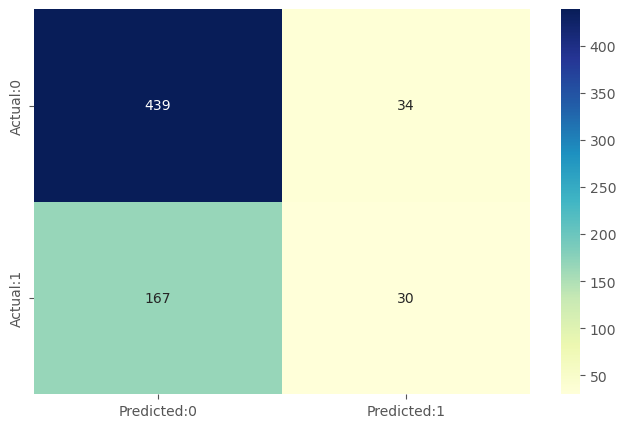

In [27]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,np.where(result.predict(X_test) <0.5, 0, 1))
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

> La Matriz de Confusión muestra 439 + 30 = 469 predicciones correctas y 34 + 29 = 175 predicciones incorrectas.

>>  - Verdaderos Positivos : 439
>>  - Verdaderos Negativos: 30
>>  - Falsos Positivos: 34 (Error Tipo 1) 
>>  - Falsos Negativos: 167 (Error Tipo 2) 



In [53]:
VN = cm[1,1]
VP = cm[0,0]
FN = cm[1,0]
FP = cm[0,1] 
Exactitud = (VP+VN)/(VP+VN+FP+FN) #Acurracy
Sencibilidad = VP/float(VP+FN)
Especificidad = VN/float(VN+FP)

print(f'Exactitud :{100*Exactitud}%','\n',
f'Sencibilidad :{100*Sencibilidad}%','\n',
f'Especificidad :{100*Especificidad}%','\n') 

Exactitud :70.0% 
 Sencibilidad :72.44224422442245% 
 Especificidad :46.875% 



Los canales de res que no se rechazan se estimaron con una precisión del 72.4% con una clasificación basada en un umbral de prediciones probabilisticas de 0.5. Mientras que ls canales de res que se rechazan se estimaron con una precisión del 46.9%. El modelo es más específico que sensible.

La exactitud en la predición en total fue del 70% tomando el umbral de predicción probabilistica mencionado.

El Indice kappa de 0.54 nos diceque hay una concordancia Moderada entre los resultados predecidos por el modelo y los valores observados

In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_test, np.where(result.predict(X_test) <0.5, 0, 1)))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81       473
           1       0.47      0.15      0.23       197

    accuracy                           0.70       670
   macro avg       0.60      0.54      0.52       670
weighted avg       0.65      0.70      0.64       670



## Predicciones probabilísticas con Umbral 0.5
Miremos las probabilidades con un umbral de 0.5

In [31]:
Pred = result.predict(X_test)
Pred = pd.DataFrame(Pred, columns=['Prob de no rechazar canales (0)'])
Pred ['Prob de rechazar canales (1)'] = 1 - Pred 
Pred.head()

,Prob de no rechazar canales (0),Prob de rechazar canales (1)
1730,0.545505,0.454495
1831,0.546126,0.453874
362,0.301361,0.698639
1402,0.553235,0.446765
78,0.273565,0.726435


## Bajando y subiendo el Umbral

In [112]:
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
Umbral = pd.DataFrame(np.zeros((9,5)), columns=["Umbral", "Sensibilidad", "Especificidad", "Exactitud", "AUC"])
for i in range(1,10):
    cm2=0
    y_pred_prob_yes=logreg.predict_proba(X_test)
    y_pred2=binarize(y_pred_prob_yes, threshold = i/10)[:,1]
    cm2=confusion_matrix(y_test,y_pred2)
    VN2 = cm2[1,1]
    VP2 = cm2[0,0]
    FN2 = cm2[1,0]
    FP2 = cm2[0,1] 
    Exactitud2 = (VP2+VN2)/(VP2+VN2+FP2+FN2) #Acurracy
    Sencibilidad2 = VP2/float(VP2+FN2)
    Especificidad2 = VN2/float(VN2+FP2)
    Umbral.loc[i-1,'Umbral'] = i/10
    Umbral.loc[i-1,'Sensibilidad'] = Sencibilidad2 
    Umbral.loc[i-1,'Especificidad'] = Especificidad2 
    Umbral.loc[i-1,'Exactitud'] = Exactitud2
    Umbral.loc[i-1,'AUC'] = roc_auc_score(y_test,y_pred2)

Umbral

,Umbral,Sensibilidad,Especificidad,Exactitud,AUC
0,0.1,0.800000,0.296923,0.311940,0.506761
1,0.2,0.864865,0.339080,0.455224,0.584545
2,0.3,0.801700,0.400631,0.611940,0.621489
3,0.4,0.750466,0.473684,0.695522,0.585903
4,0.5,0.722403,0.481481,0.702985,0.536392
5,0.6,0.710769,0.450000,0.702985,0.511215
6,0.7,0.707207,0.500000,0.705970,0.502962
7,0.8,0.705970,NaN,0.705970,0.500000
8,0.9,0.705970,NaN,0.705970,0.500000


El modelo se comporta solo un poco mejor cuando el Umbral sube a 0.7

# Curva ROC

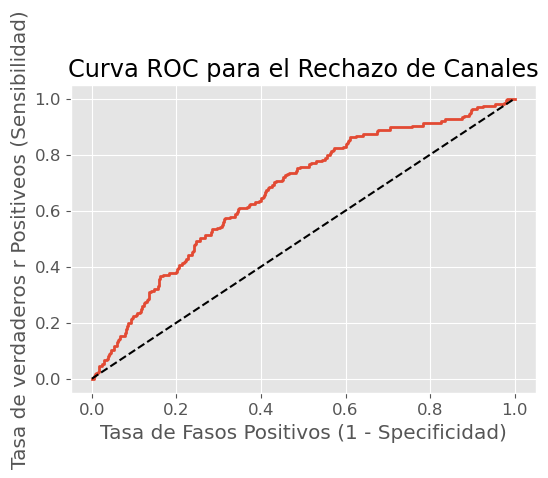

In [98]:
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_prob_yes[:,1])
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('Curva ROC para el Rechazo de Canales')
plt.xlabel('Tasa de Fasos Positivos (1 - Specificidad)')
plt.ylabel('Tasa de verdaderos r Positiveos (Sensibilidad)')
plt.show()

In [55]:
AUC

NameError: name 'AUC' is not defined